In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray
from matplotlib import pyplot as plt
import seaborn as sns
import codebase

In [2]:
from codebase import volume_pipeline

# Load data

In [3]:
res_ref = codebase.load_data.load_formatted_usbr_data('Mohave',monthly=True)
print(res_ref.columns)

Index(['Lake/Reservoir Elevation [ft]', 'Lake/Reservoir Release - Total [af]',
       'Lake/Reservoir Release - Total [cfs]', 'Lake/Reservoir Storage [af]',
       'Water Temperature [DegF]'],
      dtype='object', name='Variable')


In [4]:
res_shp = codebase.load_data.load_GRanD()

In [5]:
# Volume pipeline with crs projection
dem_DA , fw_DA = volume_pipeline.create_aligned_DEM_CYGNSS_subsets('parker',res_shp,epsg_code=54017)
fw_diff_DA = volume_pipeline.difference_over_time(fw_DA)
change_cond_DA = volume_pipeline.decide_expansion_or_shrinkage_vectorize(fw_diff_DA, input_core_dims = ['y','x'])
test_vol = volume_pipeline.calculate_rough_volume(dem_DA,fw_DA,fw_diff_DA,change_cond_DA,area_kwargs = {'input_core_dims' : [['y','x']], "vectorize": True})

# Plotting functions

In [6]:
def combine_ref_calc_data(ref_series,calc_series):
    combo_data = pd.concat([ref_series, calc_series],axis=1)
    combo_data.columns = ['Reference','Calculated']
    return combo_data

In [7]:
def calc_min_max_from_df(df,precision=0):
    mn = np.round(df.values.min(),precision)
    mx = np.round(df.values.max(),precision)
    return mn , mx

In [8]:
def square_existing_plot(ax,mn=0,mx=1):
    ax.set_xlim([mn, mx])
    ax.set_ylim([mn, mx])
    ax.set_aspect('equal', adjustable='box')
    ax.grid()
    return ax

In [9]:
def add_best_fit_line_to_existing_plot(ax,lin_regress_vals,mn=0,mx=1):
    x = [mn, mx]
    m = lin_regress_vals['slope'].values
    b = lin_regress_vals['intercept'].values
    y = m*x+b
    ax.plot(x,y)
    return ax

In [10]:
def scatter_with_best_fit(ref_data,calc_data,plt_kwargs={},mnmx_precision=0):
    lin_regress_vals = codebase.time_series_calcs.linregress_wrap(ref_data,calc_data.to_frame())
    print(lin_regress_vals)
    
    combo_data = combine_ref_calc_data(ref_data,calc_data)
    mn , mx = calc_min_max_from_df(combo_data,precision=mnmx_precision)
    
    ax = combo_data.plot(x='Reference',y='Calculated',c=combo_data.index,kind='scatter')
    
    add_best_fit_line_to_existing_plot(ax,lin_regress_vals,mn,mx)
    
    square_existing_plot(ax,mn,mx)
    return combo_data, lin_regress_vals, ax

# Area comparison

In [11]:
res_calc_area_m2 = codebase.area_calcs.CYGNSS_001_area_calculation(fw_DA)
res_calc_area_m2 = pd.Series(data = res_calc_area_m2, index = fw_DA['time'])

In [41]:
# Convert nominal area to pd.Series input
nominal_area_ac = 20400
nominal_area_m2 = codebase.utils.convert_from_ac_to_m2(nominal_area_ac)
res_ref_data = pd.Series(data = nominal_area_m2, index = res_calc_area_m2.index)
noise = np.random.normal(0,0.1,[len(res_ref_data),])
res_ref_area = res_ref_data + noise
print(nominal_area_m2)

# For Lake Powell
# res_ref_area_ac = res_ref['Lake/Reservoir Area [acres]']
# res_ref_area = codebase.utils.convert_from_ac_to_m2(res_ref_area_ac)

82555862.4


In [29]:
area_calc_match , area_ref_match = codebase.time_series_calcs.intersecting_timeframes(res_calc_area_m2,res_ref_area,buffer=0)

             slope           intercept   r_value   p_value          std_err
0 -60833893.762042  5022194769576916.0 -0.219409  0.101036  36475055.705596


(70000000.0, 260000000.0)

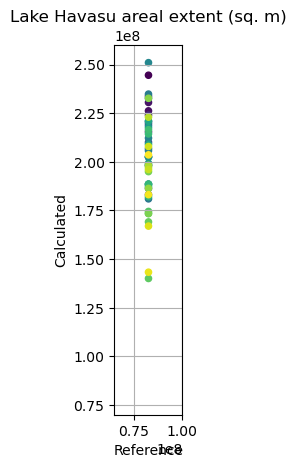

In [40]:
outputs = scatter_with_best_fit(ref_data=area_ref_match , calc_data = area_calc_match, mnmx_precision=-6)
outputs[2].set_xlabel('Reference')
outputs[2].set_ylabel('Calculated')
outputs[2].set_title('Lake Havasu areal extent (sq. m)');

# subset
outputs[2].set_xlim([0.65e8,1e8])
outputs[2].set_ylim([0.70e8,2.6e8])

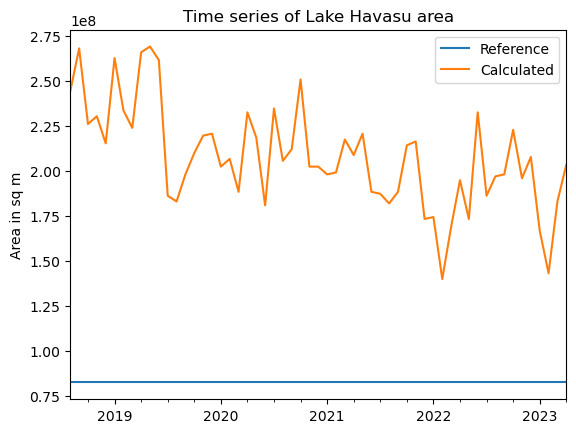

In [42]:
outputs[0].plot()
plt.title('Time series of Lake Havasu area')
plt.ylabel('Area in sq m');

# Elevation comparison

In [ ]:
from scipy.stats import norm
norm_fits = volume_pipeline.loop_through_time_series_to_get_fit_params(dem_DA, fw_DA, 1, norm)
norm_elev_m = [val[0] for val in norm_fits]
norm_elev_series_m = pd.Series(index=fw_DA['time'], data = norm_elev_m)

In [ ]:
res_ref_elev_ft = res_ref['Lake/Reservoir Elevation [ft]']
res_ref_elev_m = codebase.utils.convert_from_ft_to_m(res_ref_elev_ft)

elev_calc_norm_match ,elev_ref_match = codebase.time_series_calcs.intersecting_timeframes(norm_elev_series_m,res_ref_elev_m,buffer=0)

In [ ]:
outputs = scatter_with_best_fit(calc_data=elev_calc_norm_match , ref_data = elev_ref_match)
outputs[2].set_xlabel('Reference (m)')
outputs[2].set_ylabel('Calculated (m)')
outputs[2].set_title('Lake Havasu elevation (m)');

subset_dict = {'Powell':([1065,1105],[1135,1165]),
               'Mead'  :([310,340]  ,[380,410]),
               'Havasu':([130,140]  ,[210,240])}

location = 'Havasu'
# subset by location
outputs[2].set_xlim(subset_dict[location][0])
outputs[2].set_ylim(subset_dict[location][1])


In [ ]:
outputs[0].plot()
plt.title('Time series of Lake Havasu elevation')
plt.ylabel('Elevation in m');